In [1]:
import pandas as pd
import numpy as np

In [2]:
file = open('beerguide.txt', 'rt')
lines = file.readlines()
file.close()

lines[:] = [element for element in lines if element != '\n' ]
lines = [i.split('\n', 1)[0] for i in lines]

In [3]:
#Get the list of all 79 beers
a = lines.index('Table of Contents')
b = lines.index('Specialty Beer')

beerlist = lines[a:b+1]
beerlist[:] = [element for element in beerlist if '\ue004' not in element][1:]

In [4]:
#Replace irregular characters produced from converting pdf
word_replace_dict = {'\xa0': ' ', 
                     '\xad': '-',
                     '\x0c':'',
                    '\ue000':'B',
                    '\ue001':'E',
                    '\ue002':'S',
                    '\ue004':'s',
                    '\ue006':'y'}
beerdes = lines[b+1:]

for k,v in word_replace_dict.items():
    beerdes = [word.replace(k,v) for word in beerdes]

In [5]:
#List all the features we want to include in the model
feature = ['IBU', 'BU:GU', 'CO2 Volumes', 'Apparent Attenuation', 'Alcohol', 
             'Collar of Foam (Head Retention)', 'Collar of Foam (Texture)',
            'Hop Aroma/Flavor', 'Hop bitterness','Malt Aroma/Flavor',
            'Palate Body', 'Palate Carbonation', 'Palate Length/Finish', 'Esters']

In [6]:
#Create a dictionary that lists values for all the features
def beer_info(beer,character):
    l = []
    for i in range(len(character)):
        if character[i] == 'Alcohol':
            l.append([beer [beer.index('Alcohol')+1]][0])
        
        else:
            a = [element for element in beer if character[i] in element]
            if a:
                l.append(a[0].split(character[i],1)[1])
            else:
                l.append(np.nan)
               
    return l

In [7]:
beer_dic = {}

for j in range(len(beerlist)):
    if j == len(beerlist)-1:
        b = beerdes[beerdes.index(beerlist[j]):]
    else:
        b = beerdes[beerdes.index(beerlist[j]):beerdes.index(beerlist[j+1])]
    beer_dic[beerlist[j]] = beer_info(beer = b, character = feature)

In [8]:
#Convert dictionary to dataframe
data = pd.DataFrame(beer_dic, index= feature).transpose()
data.fillna('None', inplace = True)

#Fix a few lost values from converting pdf
data.loc['Bohemian-Style Pilsener'].IBU = '30 - 45'
data.loc['Bohemian-Style Pilsener']['Hop bitterness'] = 'medium'

In [9]:
df = data.copy()

In [10]:
### Engineer Quantitative Features

#Clean IBU, BU:GU, Apparent Attenuation
#Use mid-point of the range
#If varies, use mid_point of the entire range. And Create another column that flags it if its value was varies.

midPoint = {'IBU':50, 'BU:GU':0.5, 'Apparent Attenuation': 2.5}
column_names = list(midPoint.keys())

for i in range(len(column_names)):
    df[column_names[i]] = df[column_names[i]].str.strip()
    df[column_names[i]+'_varies'] = [1 if 'varies' in df[column_names[i]][w].lower() else 0 for w in range(len(df))]
    df[column_names[i]].loc[df[column_names[i]] == 'Varies'] = '{x} - {x}'.format(x = midPoint[column_names[i]])
    df[column_names[i]] = (df[column_names[i]].str.split(' ').str[0].astype(float) + df[column_names[i]].str.split(' ').str[2].astype(float))/2 
    
#Clean CO2 Volumes
#Use mid-point of the range
#If varies, use mid_point of the entire range. And Create another column that flags it if its value was varies.
#If approximately, use the approximation value

df['CO2 Volumes'] = df['CO2 Volumes'].str.strip()
df['CO2 Volumes_varies'] = [1 if 'varies' in df['CO2 Volumes'][w].lower() else 0 for w in range(len(df))]
df['CO2 Volumes'].loc[df['CO2 Volumes'] == 'Varies'] = '2.5 - 2.5'
df['CO2 Volumes'] = df['CO2 Volumes'].str.replace(r'\b approximately', '')

CO2_1st_all = df['CO2 Volumes'].str.split(' ').str[0].astype(float)
CO2_3rd_all = df['CO2 Volumes'].str.split(' ').str[2].astype(float)
CO2_1st_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[0].astype(float)
CO2_3rd_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[2].astype(float)

df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == True] = CO2_1st_all
df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False] = (CO2_1st_no_nan + CO2_3rd_no_nan) / 2

/Users/AndreaWenYiWang/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
#Engineer Qualitative features

qualitative_features_binary = {
    'Alcohol': 
    {'Not_Det':['not detectable'], 'Mild':['mild'], 'Noticeable':['noticeable'], 'Varies':['varies'], 
     'Harsh':['hot', 'harsh']}, 
    
    'Collar of Foam (Head Retention)':
    {'Poor':['poor'], 'Mod':['moderate'], 'Good':['good'], 'Varies':['varies']},
    
    'Collar of Foam (Texture)':
    {'Thin':['thin'], 'Intrpt':['interrupted'],'Foamy':['foam'], 'Fluffy':['fluf'], 'Rocky':['rock'],
    'Mousse':['mous'], 'Varies':['varies']}, 
    
    'Palate Body':
    {'Drying':['dry'], 'Soft':['soft'], 'Mod':['moderate'], 'Mthct':['mouth-coating'], 'Sticky':['stick'], 
     'Varies':['varies']},
    
    'Palate Carbonation':
    {'VLow':['very low'], 'Low':['low'], 'Med':['medium'], 'High':['high']},
    
    'Palate Length/Finish':
    {'Short':['short'], 'Med':['medium'], 'Long':['long'], 'Varies':['varies']},
    'Hop bitterness':{'minimal':['none,','absent', 'not perceived', 'very low', 'minimal', 'not perceived'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong']},
    
    'Hop Aroma/Flavor':
    {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong'],
    'flower':['flower','floral'], 'citrus':['citrus'], 'wood':['wood', 'pine', 'rust'], 
     'varies':['varies', 'are evident over a full range from low to high', "may be evident at the brewer's discretion"]},
    
    'Malt Aroma/Flavor':
    {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong', 'intense'],
    'varies':['varies'], 
     'wheat':['wheat', 'bread', 'toast', 'biscuit', 'grain'], 
     'sweet': ['sweet', 'choco', 'cocoa', 'caram','toffee', 'candy', 'honey'], 
     'dry':['dry']},
    
    'Esters':
    {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal', 'not common to style'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong', 'intense'],
    'varies':['varies'],
     'Fruit':['fruit', 'citrus','orange','lemon','banana','cherry','pear','apple','grape','plum','prune', 'fig', 'raisin'],
    'Smoke':['smok'], 'Pine':['pine']}    
}

feature_key = list(qualitative_features_binary.keys())
for i in feature_key:
    for k,v in qualitative_features_binary[i].items():
        df[str(i) + '_'+ str(k)] = [1 if any(x in df[i][w].lower() 
                                             for x in qualitative_features_binary[i][k]) 
                                    else 0 for w in range(len(df))]
    df.drop(i,1,inplace = True)

Clustering method: average
Cophenetic Correlation Coefficient: 0.949


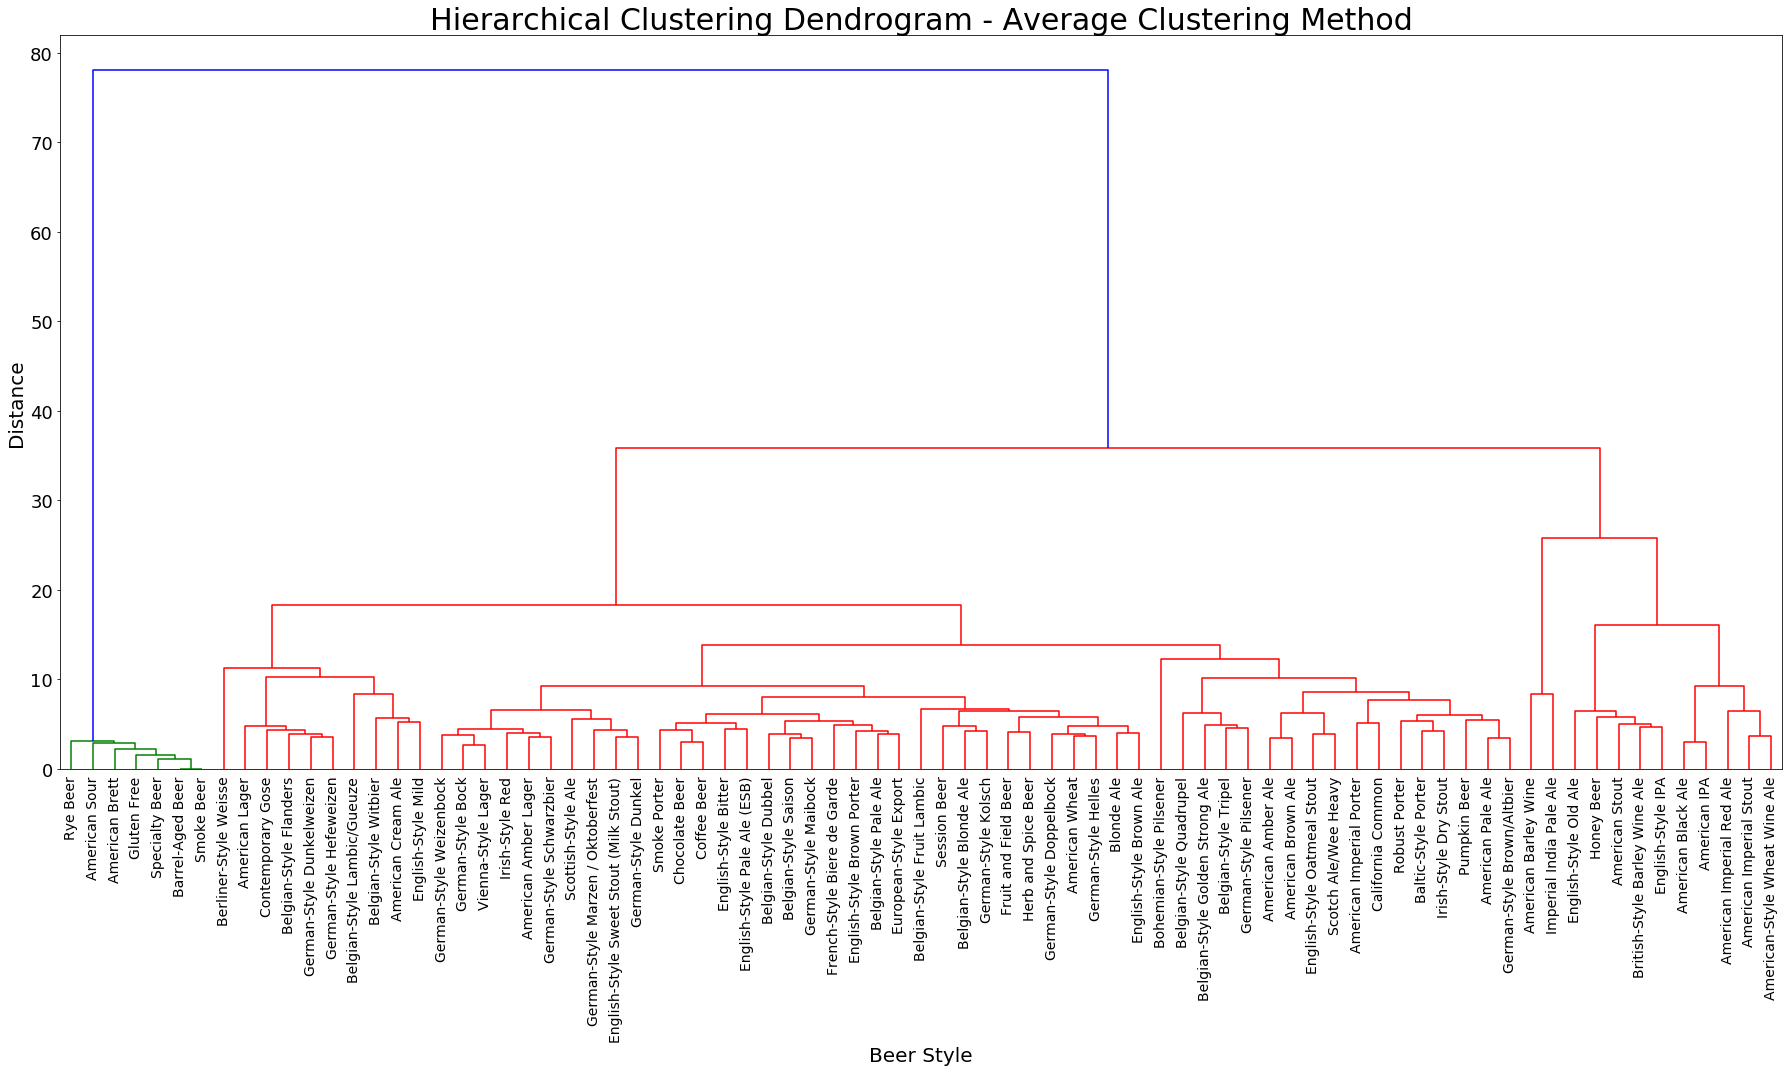

Clustering method: centroid
Cophenetic Correlation Coefficient: 0.948


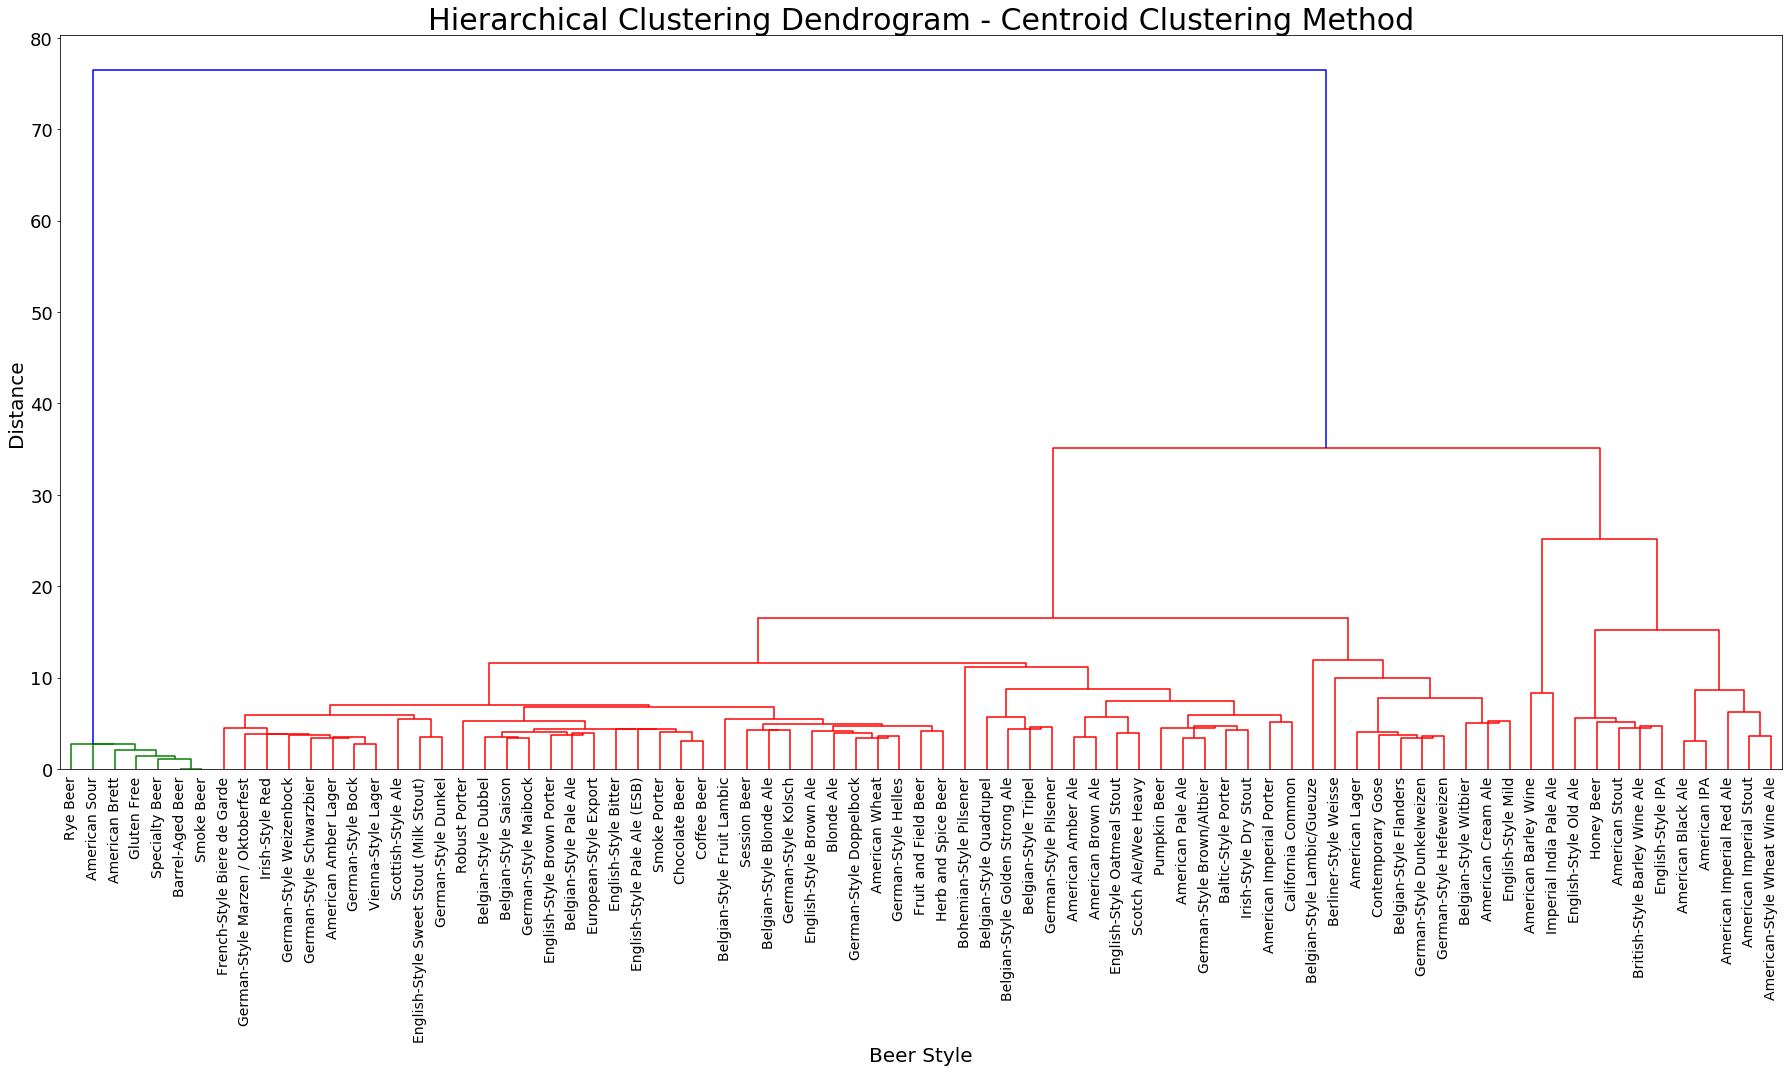

Clustering method: ward
Cophenetic Correlation Coefficient: 0.885


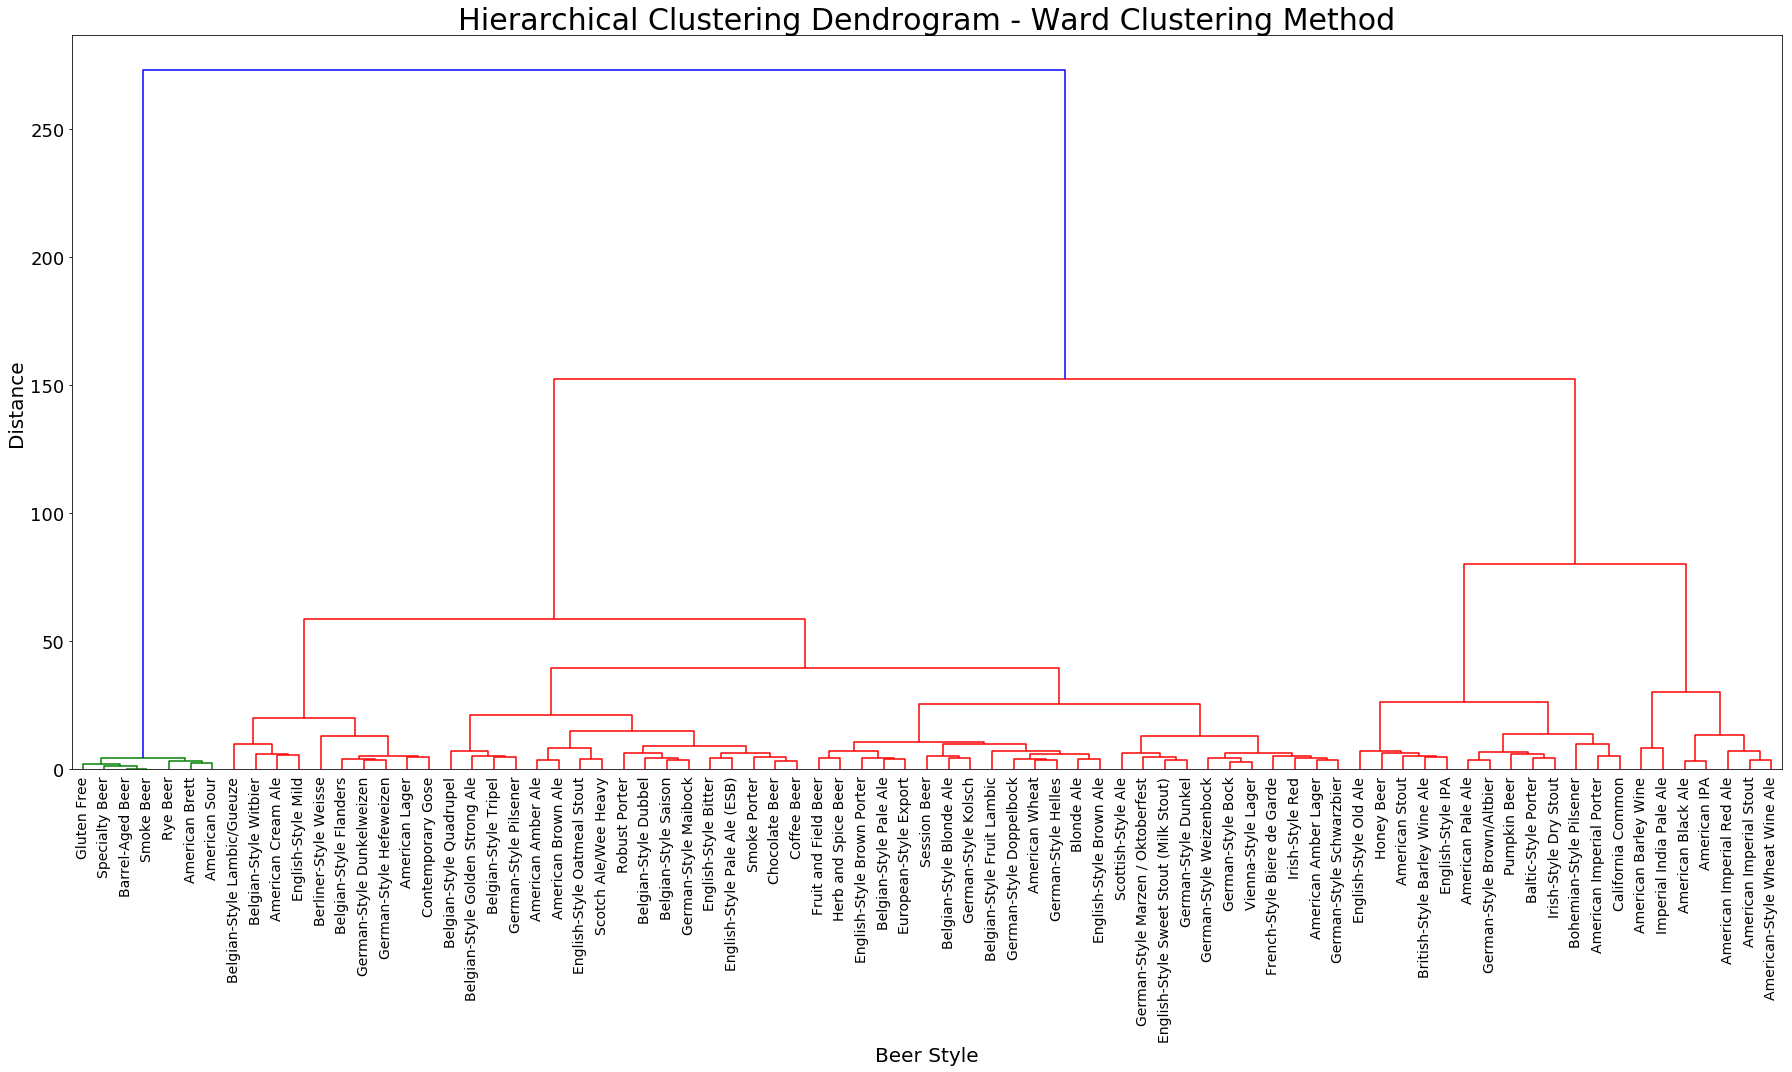

Clustering method: complete
Cophenetic Correlation Coefficient: 0.880


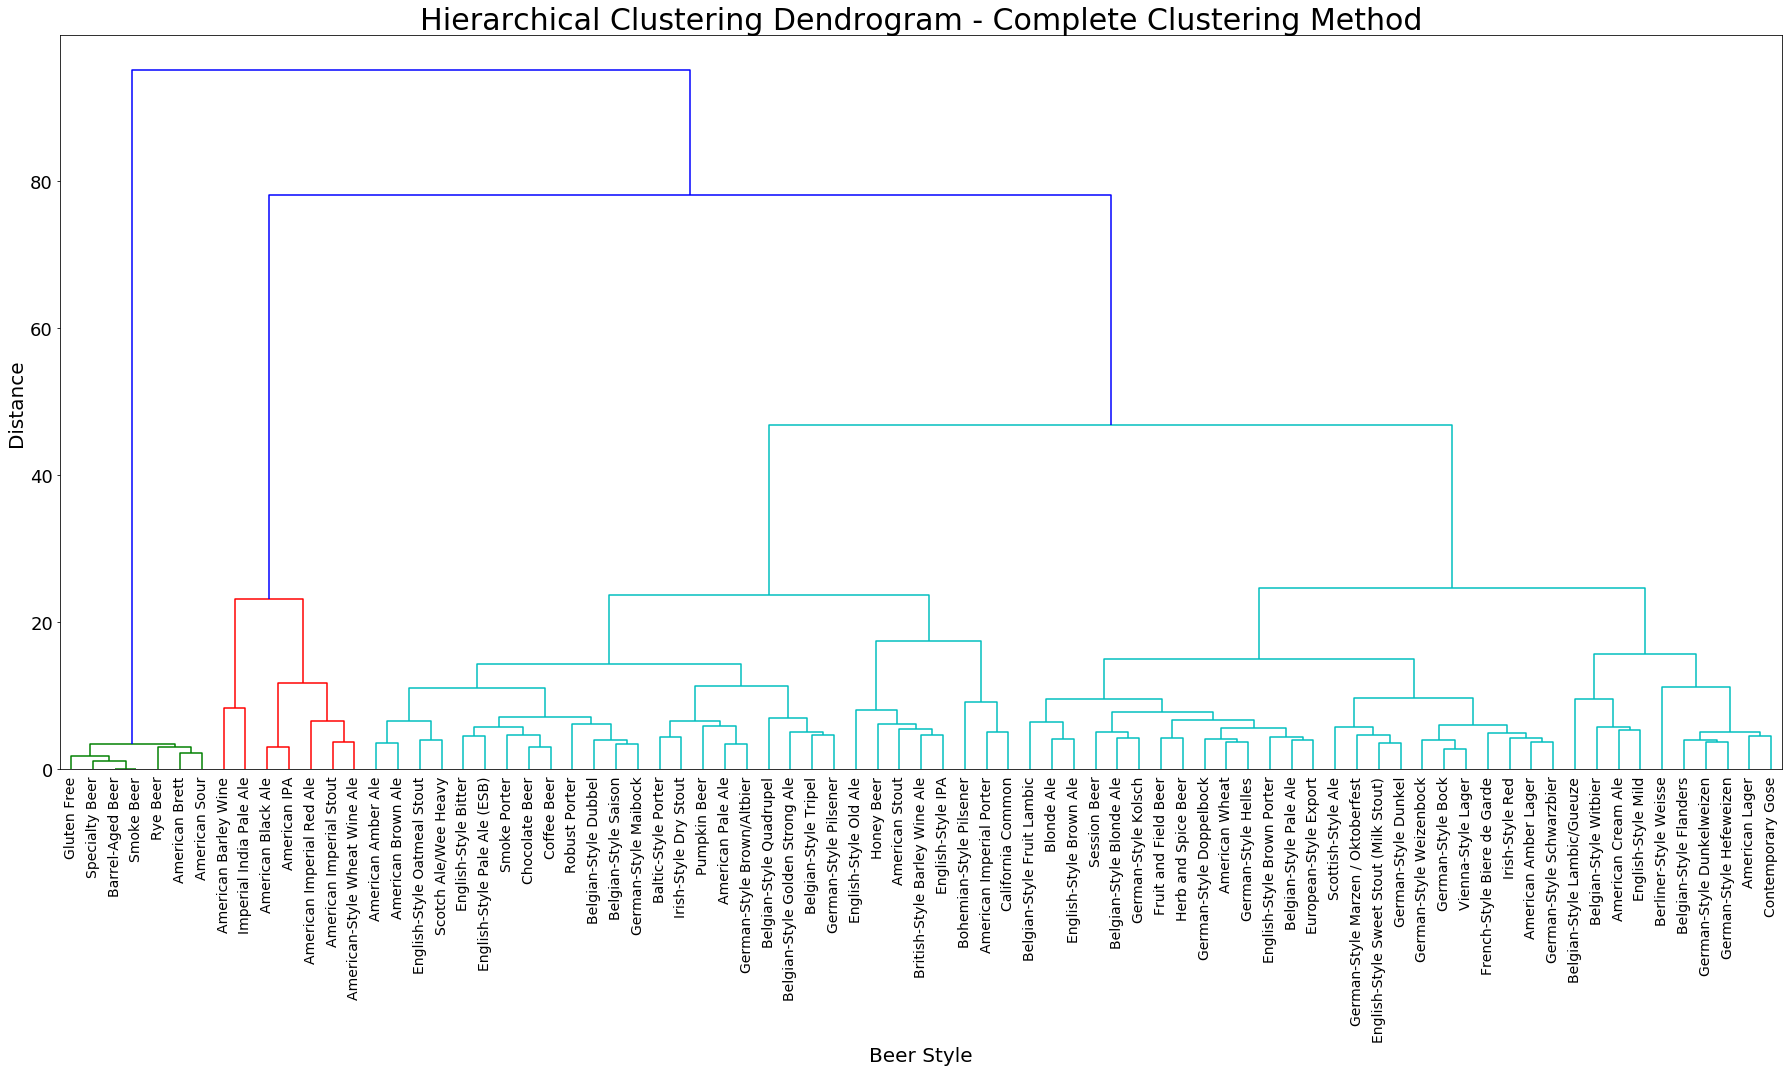

Clustering method: median
Cophenetic Correlation Coefficient: 0.917


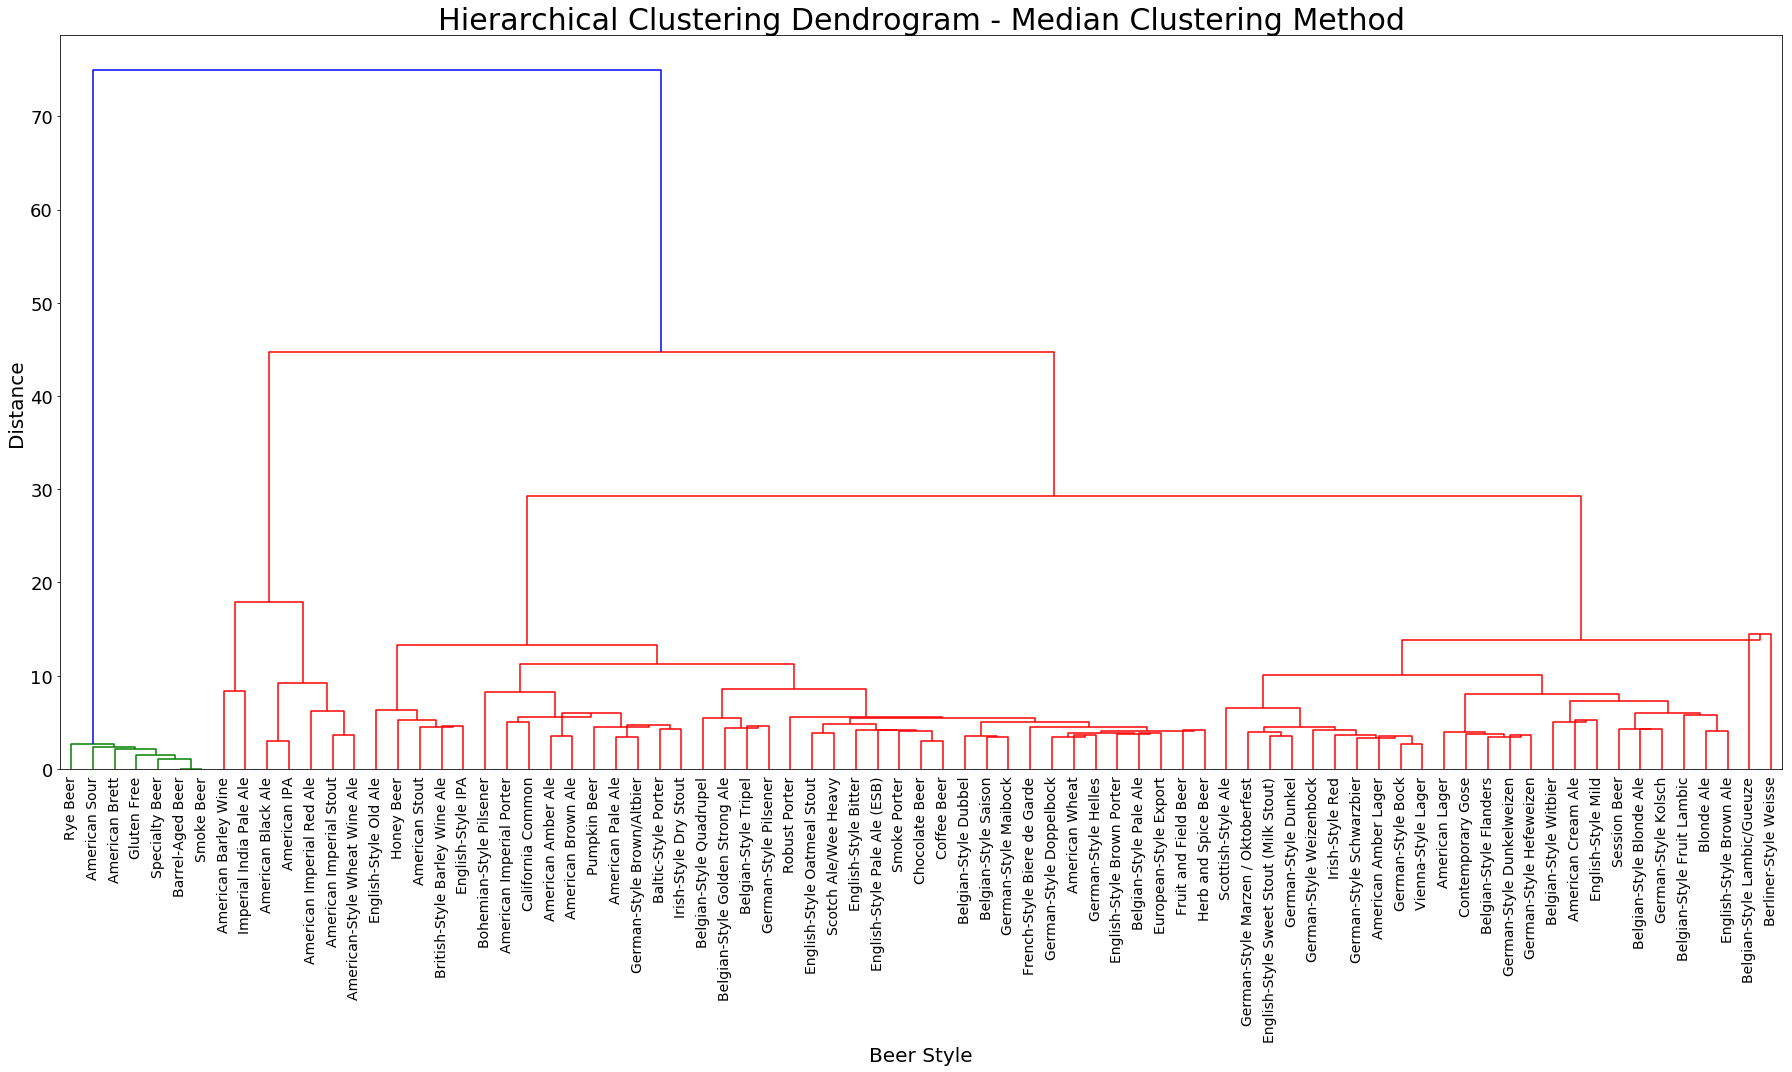

Clustering method: single
Cophenetic Correlation Coefficient: 0.894


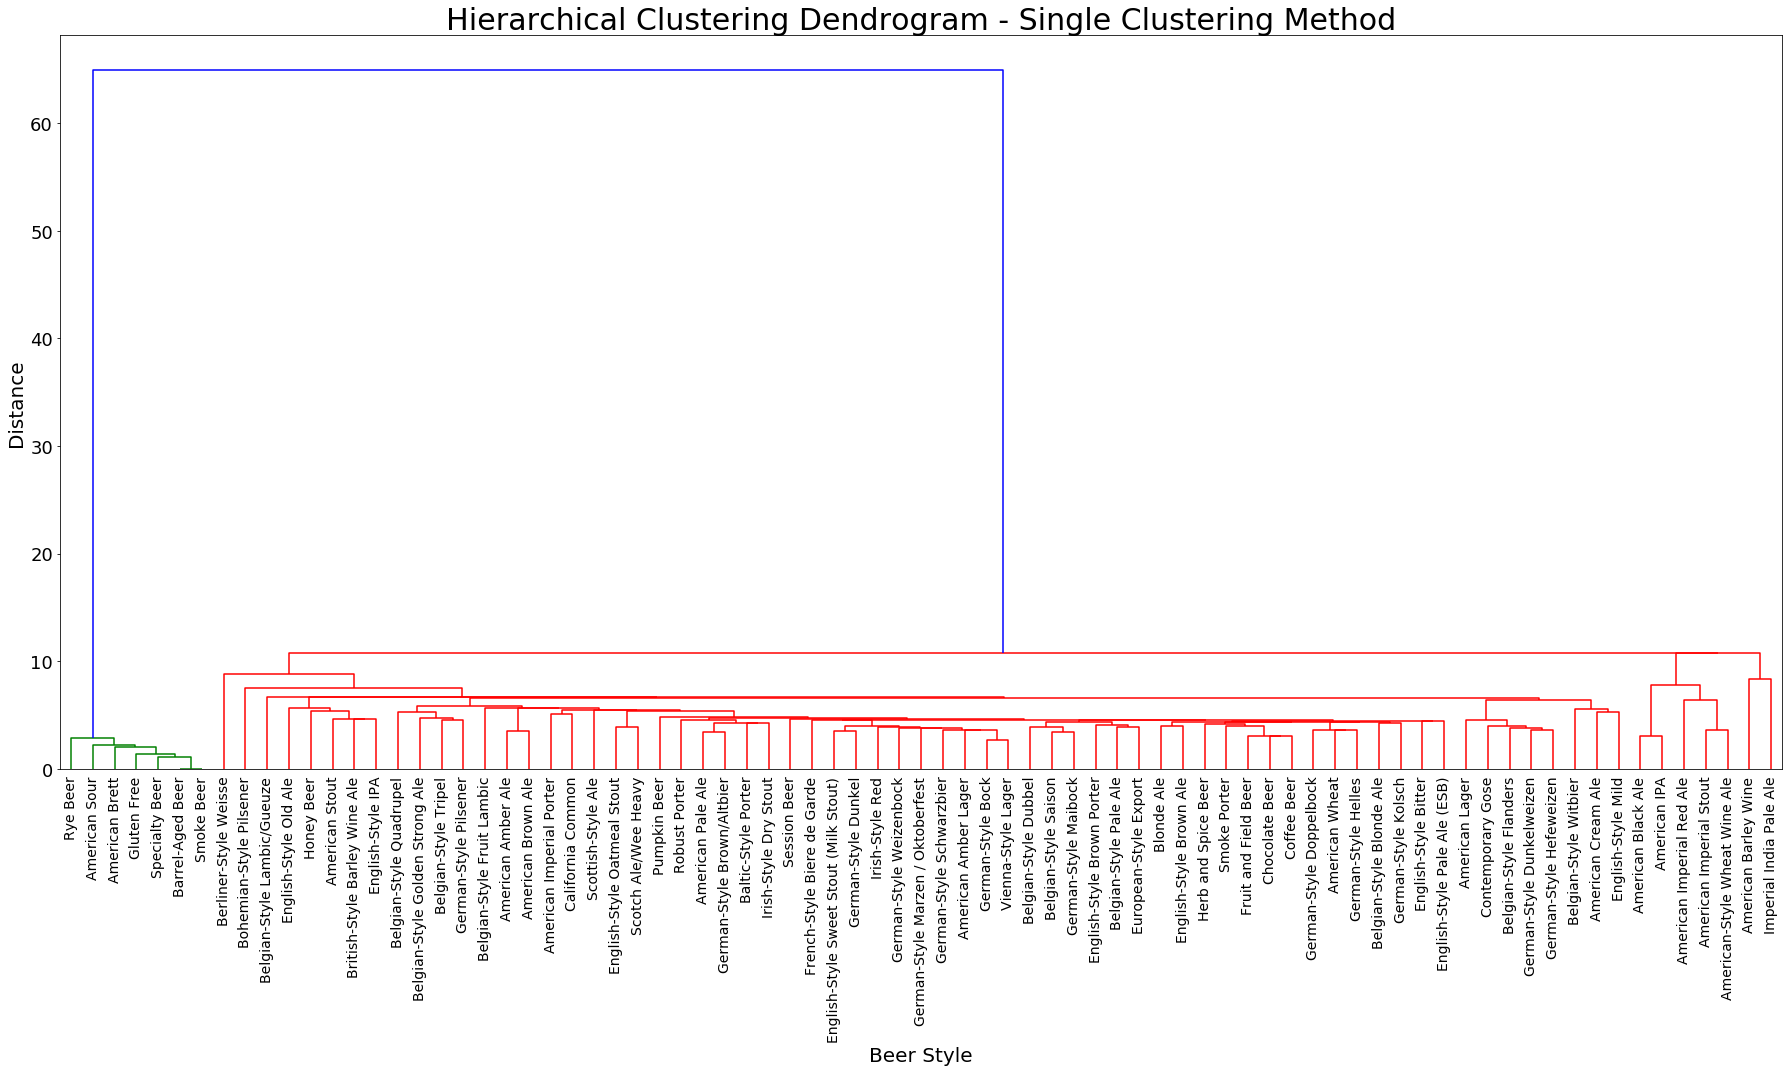

Clustering method: weighted
Cophenetic Correlation Coefficient: 0.933


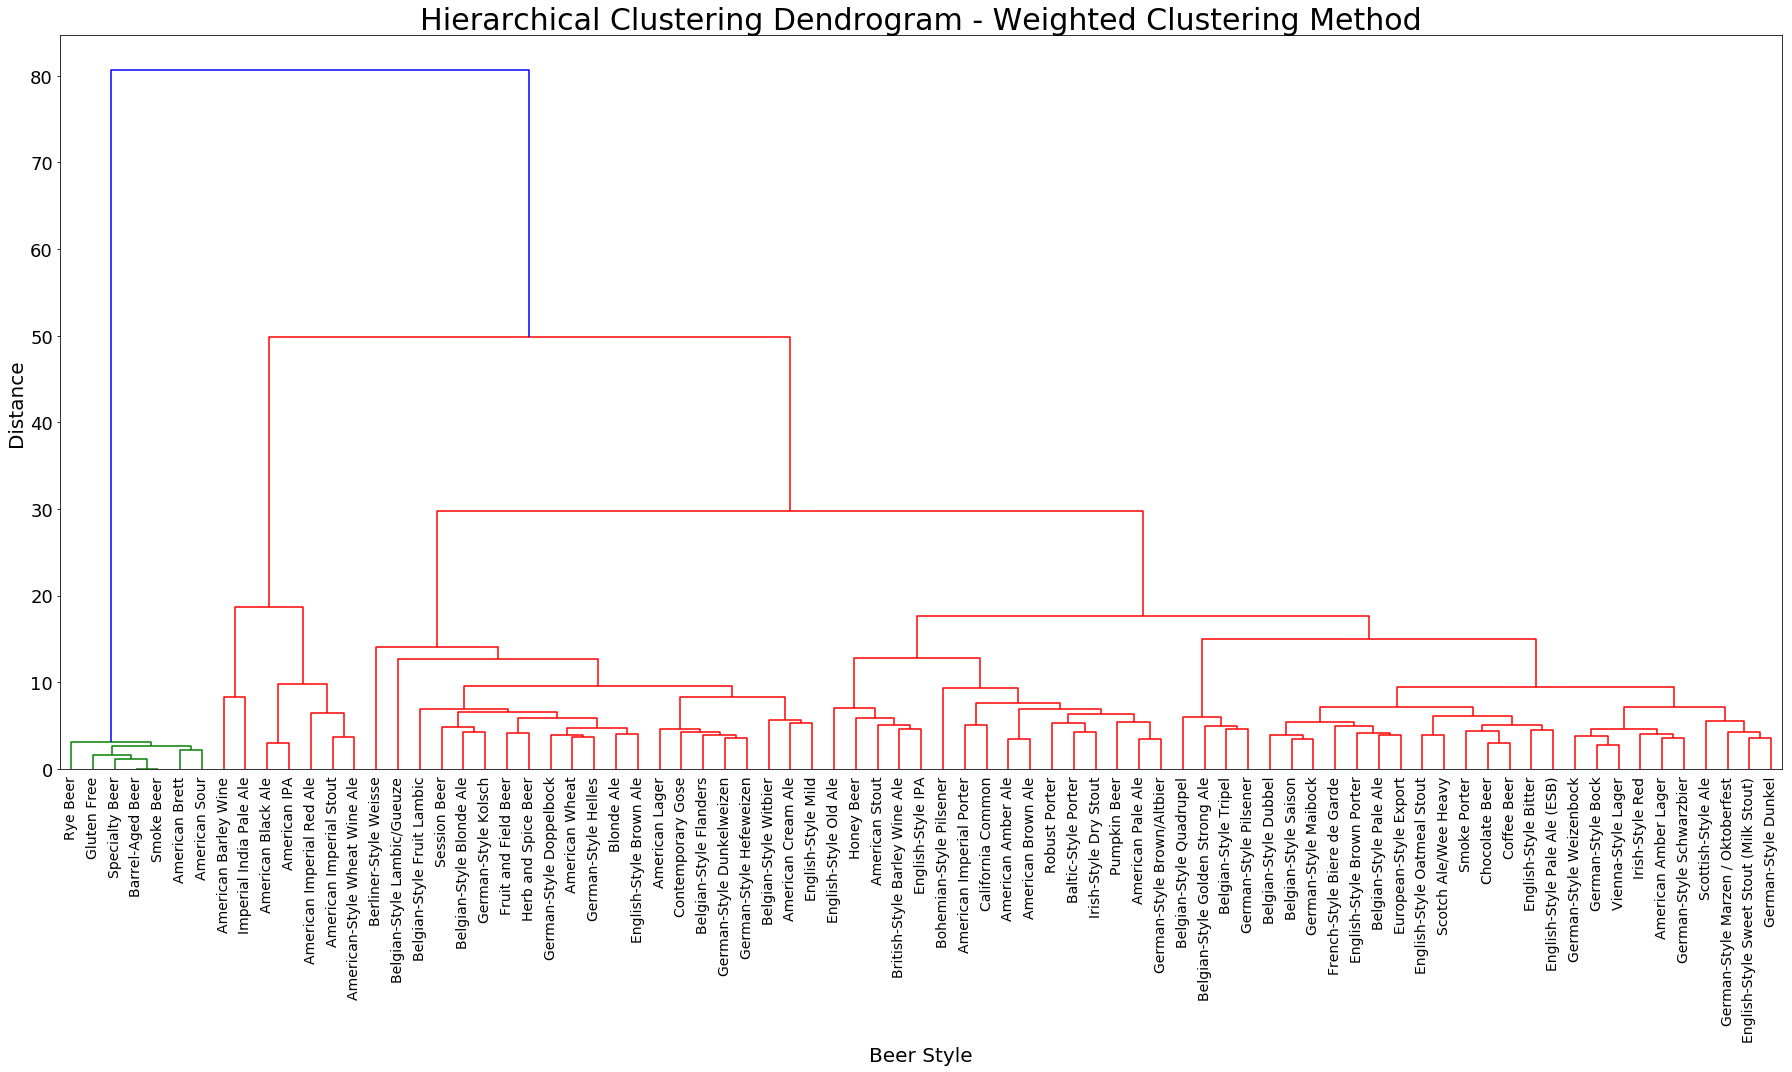

In [17]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

##Hierarchical Clustering and Plot Dendrogram

def cluster(metrics, max_d = None):
    fit = linkage(df, metrics)
    c, coph_dists = cophenet(fit, pdist(df))
    print('Clustering method: {}\nCophenetic Correlation Coefficient: {:.3f}'.format(metrics,c)) 
    
    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111)

    dendrogram(fit, leaf_rotation=90., leaf_font_size=8.)
    title = 'Hierarchical Clustering Dendrogram - ' + metrics.capitalize() + ' Clustering Method'
    plt.title(title,fontsize = 30)
    plt.xlabel('Beer Style',fontsize = 20)
    plt.ylabel('Distance',fontsize = 20)
    plt.yticks(fontsize=18)
    plt.plot([0, 10000], [max_d, max_d], 'k--')

    #Change Xticks Labels
    xticks_txt = ' '.join(label.get_text() for label in ax.get_xticklabels()).split(' ')
    xticks_inx = []
    xticks_value = []
    for i in xticks_txt:
        xticks_inx.append(int(i))

    for i in xticks_inx:
        xticks_value.append(df.index.values[i])
    
    ax.set_xticklabels(xticks_value, fontsize = 14)
    plt.tight_layout()
    plt.savefig('{m}.png'.format(m = metrics))
    plt.show()
    return fit

linkage_metrics = ['average','centroid','ward','complete','median','single','weighted']

for i in range(len(linkage_metrics)):
    cluster(linkage_metrics[i])

Clustering method: average
Cophenetic Correlation Coefficient: 0.949


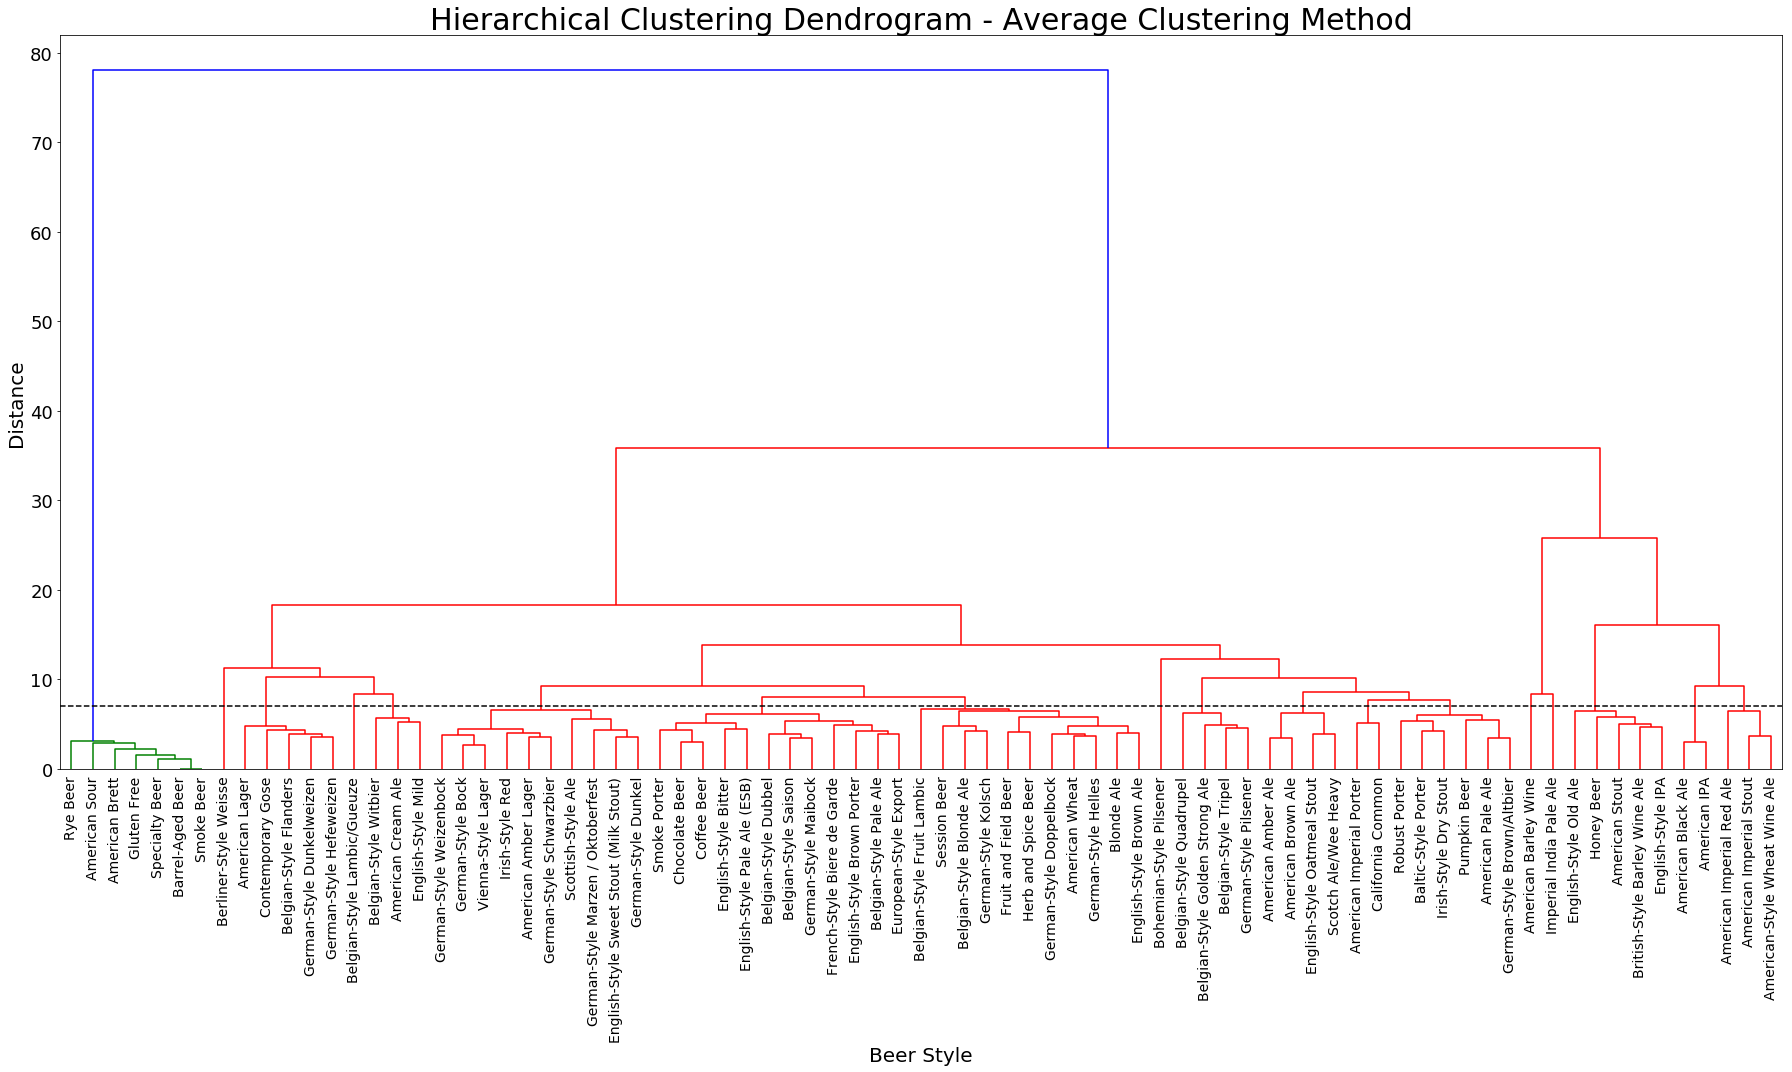

Cluster 1 contains 7 beer styles:
 ['American Brett', 'American Sour', 'Barrel-Aged Beer', 'Gluten Free', 'Rye Beer', 'Smoke Beer', 'Specialty Beer']

Cluster 2 contains 5 beer styles:
 ['American Lager', 'Belgian-Style Flanders', 'Contemporary Gose', 'German-Style Dunkelweizen', 'German-Style Hefeweizen']

Cluster 3 contains 3 beer styles:
 ['American Cream Ale', 'Belgian-Style Witbier', 'English-Style Mild']

Cluster 4 contains 1 beer styles:
 ['Belgian-Style Lambic/Gueuze']

Cluster 5 contains 1 beer styles:
 ['Berliner-Style Weisse']

Cluster 6 contains 10 beer styles:
 ['American Amber Lager', 'English-Style Sweet Stout (Milk Stout)', 'German-Style Bock', 'German-Style Dunkel', 'German-Style Marzen / Oktoberfest', 'German-Style Schwarzbier', 'German-Style Weizenbock', 'Irish-Style Red', 'Scottish-Style Ale', 'Vienna-Style Lager']

Cluster 7 contains 12 beer styles:
 ['Belgian-Style Dubbel', 'Belgian-Style Pale Ale', 'Belgian-Style Saison', 'Chocolate Beer', 'Coffee Beer', 'English

In [18]:
#Retrieve Clusters
max_d = 7 #Can be adjusted

clusters = fcluster(cluster('average', max_d), max_d, criterion='distance')
df_clusters = pd.DataFrame(clusters, columns = ['Cluster'])
clusters_list = []

cluster_dict = {}
for i in range(min(clusters),max(clusters)+1):
    cluster_dict[i] = list()
    for j in np.where(clusters == i):
        cluster_beer = df.index[j].tolist()
        cluster_dict[i].extend(cluster_beer)
        print('Cluster {} contains {} beer styles:\n {}\n'.format(i,len(cluster_beer),cluster_beer))

       

In [14]:
charact_dict = dict()
cont = ['IBU', 'BU:GU', 'CO2 Volumes', 'Apparent Attenuation']
for i in list(cluster_dict.keys()):
    clus = df.loc[cluster_dict[i]].transpose()
    clus['avg'] = clus.mean(axis=1)
    clus['std'] = clus.std(axis = 1)
    clus_with_useful_feature = clus[clus['avg']!=0]
    plt_continuous_features_df = clus_with_useful_feature.loc[cont][['avg','std']]
    yerr = plt_continuous_features_df['std'].values
    x = range(len(plt_continuous_features_df))
    y = plt_continuous_features_df['avg'].values
    
    clus_categorical_feature_values = clus_with_useful_feature.drop(cont)
    clus_useful_categorical_feature_values = clus_categorical_feature_values[clus_categorical_feature_values['avg']>=0.8]
    charact_dict[i] =  list(clus_useful_categorical_feature_values.index.values)

In [15]:
cluster_dict

{1: ['American Brett',
  'American Sour',
  'Barrel-Aged Beer',
  'Gluten Free',
  'Rye Beer',
  'Smoke Beer',
  'Specialty Beer'],
 2: ['American Lager',
  'Belgian-Style Flanders',
  'Contemporary Gose',
  'German-Style Dunkelweizen',
  'German-Style Hefeweizen'],
 3: ['American Cream Ale', 'Belgian-Style Witbier', 'English-Style Mild'],
 4: ['Belgian-Style Lambic/Gueuze'],
 5: ['Berliner-Style Weisse'],
 6: ['American Amber Lager',
  'English-Style Sweet Stout (Milk Stout)',
  'German-Style Bock',
  'German-Style Dunkel',
  'German-Style Marzen / Oktoberfest',
  'German-Style Schwarzbier',
  'German-Style Weizenbock',
  'Irish-Style Red',
  'Scottish-Style Ale',
  'Vienna-Style Lager'],
 7: ['Belgian-Style Dubbel',
  'Belgian-Style Pale Ale',
  'Belgian-Style Saison',
  'Chocolate Beer',
  'Coffee Beer',
  'English-Style Bitter',
  'English-Style Brown Porter',
  'English-Style Pale Ale (ESB)',
  'European-Style Export',
  'French-Style Biere de Garde',
  'German-Style Maibock',
  '

In [16]:
charact_dict

{1: ['IBU_varies',
  'BU:GU_varies',
  'Apparent Attenuation_varies',
  'CO2 Volumes_varies',
  'Alcohol_Varies',
  'Collar of Foam (Head Retention)_Varies',
  'Collar of Foam (Texture)_Varies',
  'Palate Body_Varies',
  'Palate Carbonation_Low',
  'Palate Carbonation_High',
  'Palate Length/Finish_Varies',
  'Hop Aroma/Flavor_varies'],
 2: ['Alcohol_Mild',
  'Collar of Foam (Head Retention)_Good',
  'Palate Carbonation_Med',
  'Palate Carbonation_High',
  'Palate Length/Finish_Med'],
 3: ['Alcohol_Not_Det',
  'Hop bitterness_low',
  'Hop Aroma/Flavor_minimal',
  'Hop Aroma/Flavor_low'],
 4: ['Alcohol_Not_Det',
  'Alcohol_Mild',
  'Collar of Foam (Head Retention)_Good',
  'Collar of Foam (Texture)_Mousse',
  'Palate Body_Drying',
  'Palate Body_Soft',
  'Palate Carbonation_VLow',
  'Palate Carbonation_Low',
  'Palate Carbonation_High',
  'Palate Length/Finish_Med',
  'Hop bitterness_minimal',
  'Hop bitterness_low',
  'Hop Aroma/Flavor_minimal',
  'Hop Aroma/Flavor_low',
  'Hop Aroma/F